# AAA Northeast Customer Clustering

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../project-AAA-northeast-member-clustering/data/processed_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3511 entries, 0 to 3510
Columns: 237 entries, Household Key to x5_Young City Solos
dtypes: float64(236), int64(1)
memory usage: 6.3 MB


In [3]:
df.columns[:30]

Index(['Household Key', 'ERS Member Cost Year 3 sum',
       'ERS Member Cost Year 3 mean', 'Length Of Residence mean',
       'Number of Children mean', 'ERS Member Cost Year 2 sum',
       'ERS Member Cost Year 2 mean', 'Cost 2014 sum', 'Cost 2016 sum',
       'ERS ENT Count Year 3 sum', 'ERS ENT Count Year 3 mean',
       'Mail Responder mean', 'Cost 2015 sum', 'PrimaryMember sum',
       'ERS ENT Count Year 1 sum', 'ERS ENT Count Year 1 mean',
       'Email Available mean', 'Income mean', 'ERS Member Cost Year 1 sum',
       'ERS Member Cost Year 1 mean', 'Cost 2019 sum', 'Credit Ranges mean',
       'Member Tenure Years mean', 'AssociateMember sum', 'Cost 2018 sum',
       'Total Cost sum', 'Member Key count', 'Do Not Direct Mail Solicit mean',
       'Cost 2017 sum', 'ERS ENT Count Year 2 sum'],
      dtype='object')

## Data Exploration
### Product Usage
Only a small portion of households using the products. The most used product has lower than 30% of the usage.

In [4]:
product_list = ['FSV CMSI Flag', 'FSV Credit Card Flag', 'FSV Deposit Program Flag', 
                'FSV Home Equity Flag', 'FSV ID Theft Flag', 'FSV Mortgage Flag',
                'INS Client Flag', 'TRV Globalware Flag', 'New Mover Flag']

In [5]:
df_product_pct = pd.DataFrame({'Percent of Usage': df[product_list].mean()}
                             ).join(pd.DataFrame({'Count of Usage': df[product_list].sum()}))
df_product_pct.sort_values(['Percent of Usage'], ascending = False)

,Percent of Usage,Count of Usage
INS Client Flag,0.281686,989.0
TRV Globalware Flag,0.179151,629.0
FSV Credit Card Flag,0.136144,478.0
FSV CMSI Flag,0.082598,290.0
FSV ID Theft Flag,0.058103,204.0
New Mover Flag,0.054400,191.0
FSV Deposit Program Flag,0.006551,23.0
FSV Mortgage Flag,0.003133,11.0
FSV Home Equity Flag,0.000854,3.0


Around 45% of the households do not use any products from AAA Northeast.

In [6]:
# Number of products bought by household
df[product_list].sum(axis=1).value_counts()

0.0    1589
1.0    1220
2.0     539
3.0     135
4.0      25
5.0       3
dtype: int64

In [7]:
1589/3511

0.4525776132156081

## Predictive Analysis
We could use classification models to predict the probability of an household buying a product on the products with more than 1% of household usage. The models build on these products should have be better in generalization than other low-usage products.

For all products with over 5% user, apply the following process for modeling:
- Upsampling
- Create training & test set based on upsampled dataset
- Grid search using Decision Tree (Set the max of depth to 10 instead of None to avoid overfitting)
- Apply bagging with 100 estimators using decision tree and best parameters

In [8]:
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [9]:
%%time
product_list_to_predict = ['FSV CMSI Flag', 'FSV Credit Card Flag', 'FSV ID Theft Flag',
                           'INS Client Flag', 'TRV Globalware Flag', 'New Mover Flag']
df_prob = pd.DataFrame()
for prod in product_list:
    # Up Sampling
    # Separate majority and minority classes
    df_majority = df[df[prod]==0]
    df_minority = df[df[prod]==1]

    # Upsample minority class
    df_minority_upsampled = resample(df_minority, 
                                     replace=True,     # sample with replacement
                                     n_samples=len(df_majority),    # to match majority class
                                     random_state=72) # reproducible results

    # Combine majority class with upsampled minority class
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])

    # Display new class counts
    print('====', prod, '====')
    print(df_upsampled[prod].value_counts())
    
    # X - exclude total costs as it will be used for clustering
    cols = [x for x in df_upsampled.columns if (x not in product_list
                                               ) & (x not in ['Household Key', 'Total Cost sum'])]
    X = df_upsampled[cols]

    # y
    y = df_upsampled[prod]
        
    # Training and testing sets    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        stratify=y,
                                                        random_state=75)
    
    # Train Decision Tree
    param_grid = {'criterion': ['gini', 'entropy'],
                  'max_depth': [8, 10, 12],
                  'min_samples_split': [2, 3, 4]}
    
    gs_dt = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
    gs_dt.fit(X_train, y_train)
    print("\n== Decision Tree ==")
    print("Best Parameters:", gs_dt.best_params_)
    print("Accuracy on Training Set:", gs_dt.best_score_)

    y_pred_prob = gs_dt.predict_proba(X_test)[:,1]
    print("Accuracy on Test Set:", gs_dt.score(X_test, y_test), 
          "AUC:", roc_auc_score(y_test, y_pred_prob))
    
    y_pred_prob = gs_dt.predict_proba(df[cols])[:,1]
    print("Accuracy on Original Dataset:", gs_dt.score(df[cols], df[prod]), 
          "AUC:", roc_auc_score(df[prod], y_pred_prob))
    
    # Train Bagging 
    dt = DecisionTreeClassifier(criterion=gs_dt.best_estimator_.criterion,
                                max_depth=gs_dt.best_estimator_.max_depth,
                                min_samples_split=gs_dt.best_estimator_.min_samples_split)
    bg =  BaggingClassifier(dt, n_estimators = 100)
    bg.fit(X_train, y_train)
    print("\n== Bagging ==")
    print("Accuracy on Training Set:", bg.score(X_train, y_train))

    y_pred_prob = bg.predict_proba(X_test)[:,1]
    print("Accuracy on Test Set:", bg.score(X_test, y_test),
          "AUC:", roc_auc_score(y_test, y_pred_prob))
    
    y_pred_prob = bg.predict_proba(df[cols])[:,1]
    print("Accuracy on Original Dataset:", bg.score(df[cols], df[prod]),
          "AUC:", roc_auc_score(df[prod], y_pred_prob))
    
    y_pred = bg.predict(df[cols])
    print("Prediction Count:")
    print(pd.Series(y_pred).value_counts(), "\n")
    
    df_prob[prod] = y_pred_prob


==== FSV CMSI Flag ====
1.0    3221
0.0    3221
Name: FSV CMSI Flag, dtype: int64

== Decision Tree ==
Best Parameters: {'criterion': 'gini', 'max_depth': 12, 'min_samples_split': 4}
Accuracy on Training Set: 0.8628018795965836
Accuracy on Test Set: 0.8525989138867339 AUC: 0.9004682459434734
Accuracy on Original Dataset: 0.8148675590999716 AUC: 0.9356812512712909

== Bagging ==
Accuracy on Training Set: 0.9668154473122453
Accuracy on Test Set: 0.9309542280837859 AUC: 0.9873441186383553
Accuracy on Original Dataset: 0.9478780974081459 AUC: 0.9898152212313589
Prediction Count:
0.0    3060
1.0     451
dtype: int64 

==== FSV Credit Card Flag ====
1.0    3033
0.0    3033
Name: FSV Credit Card Flag, dtype: int64

== Decision Tree ==
Best Parameters: {'criterion': 'gini', 'max_depth': 12, 'min_samples_split': 4}
Accuracy on Training Set: 0.7454661471328314
Accuracy on Test Set: 0.7380560131795717 AUC: 0.794681217753339
Accuracy on Original Dataset: 0.71461122187411 AUC: 0.8592822053644222

=

In [10]:
df_prob.head()

,FSV CMSI Flag,FSV Credit Card Flag,FSV Deposit Program Flag,FSV Home Equity Flag,FSV ID Theft Flag,FSV Mortgage Flag,INS Client Flag,TRV Globalware Flag,New Mover Flag
0,0.101758,0.890997,0.000000,0.00,0.021623,0.04,0.314648,0.391722,0.961056
1,0.170279,0.348028,0.000000,0.00,0.087276,0.00,0.882481,0.306575,0.112272
2,0.086913,0.174309,0.066809,0.00,0.424824,0.00,0.306660,0.589563,0.123169
3,0.206401,0.169004,0.000000,0.00,0.448306,0.00,0.220959,0.847385,0.086761
4,0.660535,0.511689,0.020911,0.05,0.180000,0.00,0.804659,0.711829,0.083666


In [11]:
df_prob.describe()

,FSV CMSI Flag,FSV Credit Card Flag,FSV Deposit Program Flag,FSV Home Equity Flag,FSV ID Theft Flag,FSV Mortgage Flag,INS Client Flag,TRV Globalware Flag,New Mover Flag
count,3511.000000,3511.000000,3511.000000,3511.000000,3511.000000,3511.000000,3511.000000,3511.000000,3511.000000
mean,0.237083,0.358491,0.123379,0.001473,0.264870,0.018365,0.415937,0.390985,0.208105
std,0.239281,0.213079,0.219358,0.030691,0.278236,0.074097,0.197004,0.203173,0.208101
min,0.001270,0.000068,0.000000,0.000000,0.000000,0.000000,0.077045,0.000476,0.003524
25%,0.077662,0.183526,0.000000,0.000000,0.000000,0.000000,0.276185,0.223023,0.076094
50%,0.125699,0.322216,0.000000,0.000000,0.151594,0.000000,0.350378,0.377098,0.124485
75%,0.319181,0.507389,0.120093,0.000000,0.513418,0.000000,0.509389,0.526871,0.255479
max,0.998997,0.980133,0.984288,1.000000,1.000000,0.999341,0.977625,0.978100,0.999592


**With high AUC on predicting all products in the original dataset, we can be confident that the probability of purchsing would be a good reference on current and potential buyers of each product.**

## Predict Cost in Next 12 Months
We can use the cost before year 2019 as year n-1, n-2, and so on to predict the cost in year 2019. Afterwards, we can use treat year 2019 as year n-1, year 2018 as year n-2, and so on to preduct the cost in year 2020. 

Based on the difinition, ERS ENT Count Year 1 and ERS Member Cost Year 1 happen in year 2019, so we can't use them to predict the cost in 2019. However, they can be used to predict the cost in 2020.

One assumption here is that the household info would remain the same in year 2020 as we don't have the projected household info of year 2020.

In [12]:
df_cost_prediction = df.drop(['Household Key', 'Total Cost sum', 
                              'ERS ENT Count Year 1 sum', 'ERS ENT Count Year 1 mean',
                              'ERS ENT Count Year 2 mean', 'ERS ENT Count Year 3 mean', 
                              'ERS Member Cost Year 1 sum', 'ERS Member Cost Year 1 mean',
                              'ERS Member Cost Year 2 mean', 'ERS Member Cost Year 3 mean'
                             ] + product_list, axis = 1)
    # Categorical variables
cat_cols = [x for x in df_cost_prediction.columns if x.startswith('x')]
for col in cat_cols:
    df_cost_prediction[col] = df_cost_prediction[col].astype('category')
df_cost_prediction = df_cost_prediction.rename(columns = 
                                               {'Cost 2018 sum': 'Cost n-1',
                                                'Cost 2017 sum': 'Cost n-2',
                                                'Cost 2016 sum': 'Cost n-3',
                                                'Cost 2015 sum': 'Cost n-4',
                                                'Cost 2014 sum': 'Cost n-5',
                                                'ERS ENT Count Year 2 sum': 'ERS ENT Count Year n-1',
                                                'ERS ENT Count Year 3 sum': 'ERS ENT Count Year n-2',
                                                'ERS Member Cost Year 2 sum': 'ERS Member Cost Year n-1',
                                                'ERS Member Cost Year 3 sum': 'ERS Member Cost Year n-2'})
df_cost_prediction.iloc[:, :25].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3511 entries, 0 to 3510
Data columns (total 25 columns):
ERS Member Cost Year n-2           3511 non-null float64
Length Of Residence mean           3511 non-null float64
Number of Children mean            3511 non-null float64
ERS Member Cost Year n-1           3511 non-null float64
Cost n-5                           3511 non-null float64
Cost n-3                           3511 non-null float64
ERS ENT Count Year n-2             3511 non-null float64
Mail Responder mean                3511 non-null float64
Cost n-4                           3511 non-null float64
PrimaryMember sum                  3511 non-null float64
Email Available mean               3511 non-null float64
Income mean                        3511 non-null float64
Cost 2019 sum                      3511 non-null float64
Credit Ranges mean                 3511 non-null float64
Member Tenure Years mean           3511 non-null float64
AssociateMember sum                351

In [13]:
df_cost_prediction.head()

,ERS Member Cost Year n-2,Length Of Residence mean,Number of Children mean,ERS Member Cost Year n-1,Cost n-5,Cost n-3,ERS ENT Count Year n-2,Mail Responder mean,Cost n-4,PrimaryMember sum,...,x5_Middle Class Melting Pot,x5_Not Set,x5_Pastoral Pride,x5_Power Elite,x5_Promising Families,x5_Significant Singles,x5_Singles and Starters,x5_Surburban Style,x5_Thriving Boomers,x5_Young City Solos
0,347.16,14.000000,0.000000,58.85,243.0,230.0,4.0,1.0,446.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,301.19,14.000000,0.000000,156.85,0.0,0.0,3.0,1.0,58.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.00,15.000000,0.000000,0.00,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,159.00,13.333333,0.666667,277.90,0.0,0.0,3.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.00,15.000000,0.000000,0.00,0.0,0.0,0.0,1.0,60.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


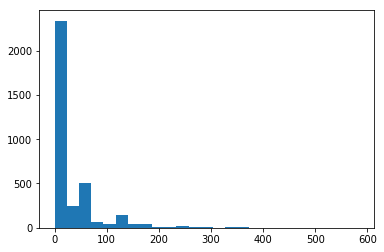

In [14]:
plt.hist(df_cost_prediction['Cost 2019 sum'], bins=25)
plt.show()

In [15]:
df_cost_prediction['Cost 2019 sum'].describe()

count    3511.000000
mean       29.002273
std        55.264674
min         0.000000
25%         0.000000
50%         0.000000
75%        58.850000
max       584.170000
Name: Cost 2019 sum, dtype: float64

In [16]:
# Percentage of households with costs greater than 0 in 2019
len(df_cost_prediction['Cost 2019 sum'
                      ][df_cost_prediction['Cost 2019 sum'
                                          ] > 0]) / len(df_cost_prediction['Cost 2019 sum'])

0.3383651381372828

**The majority of households didn't generate any costs in 2019. Therefore, the question is modified to a classification question to identify the probability of a household generating cost in 2020**

In [21]:
from sklearn.linear_model import LogisticRegression

In [22]:
X = df_cost_prediction.drop(['Cost 2019 sum'], axis=1)
# y = df_cost_prediction[['Cost 2019 sum']]
y = [1 if x > 0 else 0 for x in df_cost_prediction['Cost 2019 sum']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 28)

In [23]:
%%time
param_grid = {'C': [15-6, 1e-5, 1e-4], 
              'tol': [10, 1, 0.1], 
              'max_iter': [1000, 1500]}
gs_lr = GridSearchCV(LogisticRegression(), param_grid, cv=5)
gs_lr.fit(X_train, y_train)
print("Best Parameters:", gs_lr.best_params_)
print("Accuracy on Training Set:", gs_lr.best_score_)

y_pred_prob = gs_lr.predict_proba(X_test)[:,1]
print("Accuracy on Test Set:", gs_lr.score(X_test, y_test))
print("AUC:", roc_auc_score(y_test, y_pred_prob))

y_pred_prob = gs_lr.predict_proba(X)[:,1]
print("Accuracy on Original Dataset:", bg.score(X, y),
      "AUC:", roc_auc_score(y, y_pred_prob))

Best Parameters: {'max_iter': 1000, 'C': 9, 'tol': 10}
Accuracy on Training Set: 0.7301549848492375
Accuracy on Test Set: 0.7609108159392789
AUC: 0.7649844991566027


ValueError: Number of features of the model must match the input. Model n_features is 226 and input n_features is 217.

In [24]:
y_pred = gs_lr.predict(X_test)
pd.Series(y_pred).value_counts()

0    869
1    185
dtype: int64

In [25]:
%%time
# Train Decision Tree
param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': [2, 3, 5],
              'min_samples_split': [2, 3, 4]}

gs_dt = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
gs_dt.fit(X_train, y_train)
print("\n== Decision Tree ==")
print("Best Parameters:", gs_dt.best_params_)
print("Accuracy on Training Set:", gs_dt.best_score_)

y_pred_prob = gs_dt.predict_proba(X_test)[:,1]
print("Accuracy on Test Set:", gs_dt.score(X_test, y_test), 
      "AUC:", roc_auc_score(y_test, y_pred_prob))
    
y_pred_prob = gs_dt.predict_proba(X)[:,1]
print("Accuracy on Original Dataset:", gs_dt.score(X, y), 
      "AUC:", roc_auc_score(y, y_pred_prob))

# Train Bagging 
dt = DecisionTreeClassifier(criterion=gs_dt.best_estimator_.criterion,
                            max_depth=gs_dt.best_estimator_.max_depth,
                            min_samples_split=gs_dt.best_estimator_.min_samples_split)
bg =  BaggingClassifier(dt, n_estimators = 100)
bg.fit(X_train, y_train)
print("\n== Bagging ==")
print("Accuracy on Training Set:", bg.score(X_train, y_train))

y_pred_prob = bg.predict_proba(X_test)[:,1]
print("Accuracy on Test Set:", bg.score(X_test, y_test),
      "AUC:", roc_auc_score(y_test, y_pred_prob))
    
y_pred_prob = bg.predict_proba(X)[:,1]
print("Accuracy on Original Dataset:", bg.score(X, y),
      "AUC:", roc_auc_score(y, y_pred_prob))
    
y_pred = bg.predict(X)
print("Prediction Count:")
print(pd.Series(y_pred).value_counts(), "\n")


== Decision Tree ==
Best Parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2}
Accuracy on Training Set: 0.7492805457586144
Accuracy on Test Set: 0.7637571157495257 AUC: 0.7615898775496469
Accuracy on Original Dataset: 0.7630304756479636 AUC: 0.7779692824354899

== Bagging ==
Accuracy on Training Set: 0.7643467643467643
Accuracy on Test Set: 0.7713472485768501 AUC: 0.7763188336298894
Accuracy on Original Dataset: 0.766448305326118 AUC: 0.8018155076377205
Prediction Count:
0    2397
1    1114
dtype: int64 

Wall time: 1min 25s


In [26]:
df_2020_prediction = df.drop(['Household Key','Cost 2014 sum', 'Total Cost sum', 
                              'ERS ENT Count Year 3 sum', 'ERS ENT Count Year 1 mean',
                              'ERS ENT Count Year 2 mean', 'ERS ENT Count Year 3 mean', 
                              'ERS Member Cost Year 3 sum', 'ERS Member Cost Year 1 mean',
                              'ERS Member Cost Year 2 mean', 'ERS Member Cost Year 3 mean'
                             ] + product_list, axis = 1)
    # Categorical variables
cat_cols = [x for x in df_2020_prediction.columns if x.startswith('x')]
for col in cat_cols:
    df_cost_prediction[col] = df_cost_prediction[col].astype('category')
df_2020_prediction = df_2020_prediction.rename(columns=
                                               {'Cost 2019 sum': 'Cost n-1',
                                                'Cost 2018 sum': 'Cost n-2',
                                                'Cost 2017 sum': 'Cost n-3',
                                                'Cost 2016 sum': 'Cost n-4',
                                                'Cost 2015 sum': 'Cost n-5',
                                                'ERS ENT Count Year 1 sum': 'ERS ENT Count Year n-1',
                                                'ERS ENT Count Year 2 sum': 'ERS ENT Count Year n-2',
                                                'ERS Member Cost Year 1 sum': 'ERS Member Cost Year n-1',
                                                'ERS Member Cost Year 2 sum': 'ERS Member Cost Year n-2'})
df_2020_prediction.iloc[:, :25].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3511 entries, 0 to 3510
Data columns (total 25 columns):
Length Of Residence mean           3511 non-null float64
Number of Children mean            3511 non-null float64
ERS Member Cost Year n-2           3511 non-null float64
Cost n-4                           3511 non-null float64
Mail Responder mean                3511 non-null float64
Cost n-5                           3511 non-null float64
PrimaryMember sum                  3511 non-null float64
ERS ENT Count Year n-1             3511 non-null float64
Email Available mean               3511 non-null float64
Income mean                        3511 non-null float64
ERS Member Cost Year n-1           3511 non-null float64
Cost n-1                           3511 non-null float64
Credit Ranges mean                 3511 non-null float64
Member Tenure Years mean           3511 non-null float64
AssociateMember sum                3511 non-null float64
Cost n-2                           351

In [27]:
df_prob['Cost'] = bg.predict_proba(df_2020_prediction)[:,1]
y_pred = bg.predict(df_2020_prediction)
print("Prediction Count:")
print(pd.Series(y_pred).value_counts())

Prediction Count:
0    2412
1    1099
dtype: int64


In [28]:
df_prob.head()

,FSV CMSI Flag,FSV Credit Card Flag,FSV Deposit Program Flag,FSV Home Equity Flag,FSV ID Theft Flag,FSV Mortgage Flag,INS Client Flag,TRV Globalware Flag,New Mover Flag,Cost
0,0.101758,0.890997,0.000000,0.00,0.021623,0.04,0.314648,0.391722,0.961056,0.607269
1,0.170279,0.348028,0.000000,0.00,0.087276,0.00,0.882481,0.306575,0.112272,0.270691
2,0.086913,0.174309,0.066809,0.00,0.424824,0.00,0.306660,0.589563,0.123169,0.145711
3,0.206401,0.169004,0.000000,0.00,0.448306,0.00,0.220959,0.847385,0.086761,0.189228
4,0.660535,0.511689,0.020911,0.05,0.180000,0.00,0.804659,0.711829,0.083666,0.229335


## Clustering

In [29]:
from sklearn.cluster import KMeans

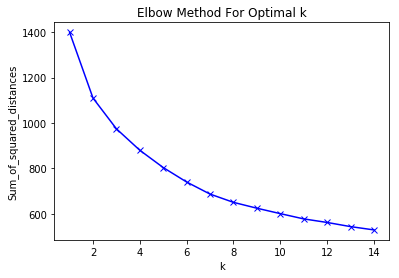

In [30]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_prob)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [31]:
df_prob = df_prob[['INS Client Flag', 'TRV Globalware Flag', 'FSV Credit Card Flag', 
                   'FSV CMSI Flag', 'FSV ID Theft Flag', 'New Mover Flag', 
                   'FSV Deposit Program Flag', 'FSV Mortgage Flag', 'FSV Home Equity Flag',
                   'Cost']]

kmeans = KMeans(n_clusters=8).fit(df_prob.iloc[:,:9])
df_prob['Cluster'] = kmeans.labels_
df_prob.head()

,INS Client Flag,TRV Globalware Flag,FSV Credit Card Flag,FSV CMSI Flag,FSV ID Theft Flag,New Mover Flag,FSV Deposit Program Flag,FSV Mortgage Flag,FSV Home Equity Flag,Cost,Cluster
0,0.314648,0.391722,0.890997,0.101758,0.021623,0.961056,0.000000,0.04,0.00,0.607269,5
1,0.882481,0.306575,0.348028,0.170279,0.087276,0.112272,0.000000,0.00,0.00,0.270691,0
2,0.306660,0.589563,0.174309,0.086913,0.424824,0.123169,0.066809,0.00,0.00,0.145711,6
3,0.220959,0.847385,0.169004,0.206401,0.448306,0.086761,0.000000,0.00,0.00,0.189228,6
4,0.804659,0.711829,0.511689,0.660535,0.180000,0.083666,0.020911,0.00,0.05,0.229335,7


In [32]:
import seaborn as sns

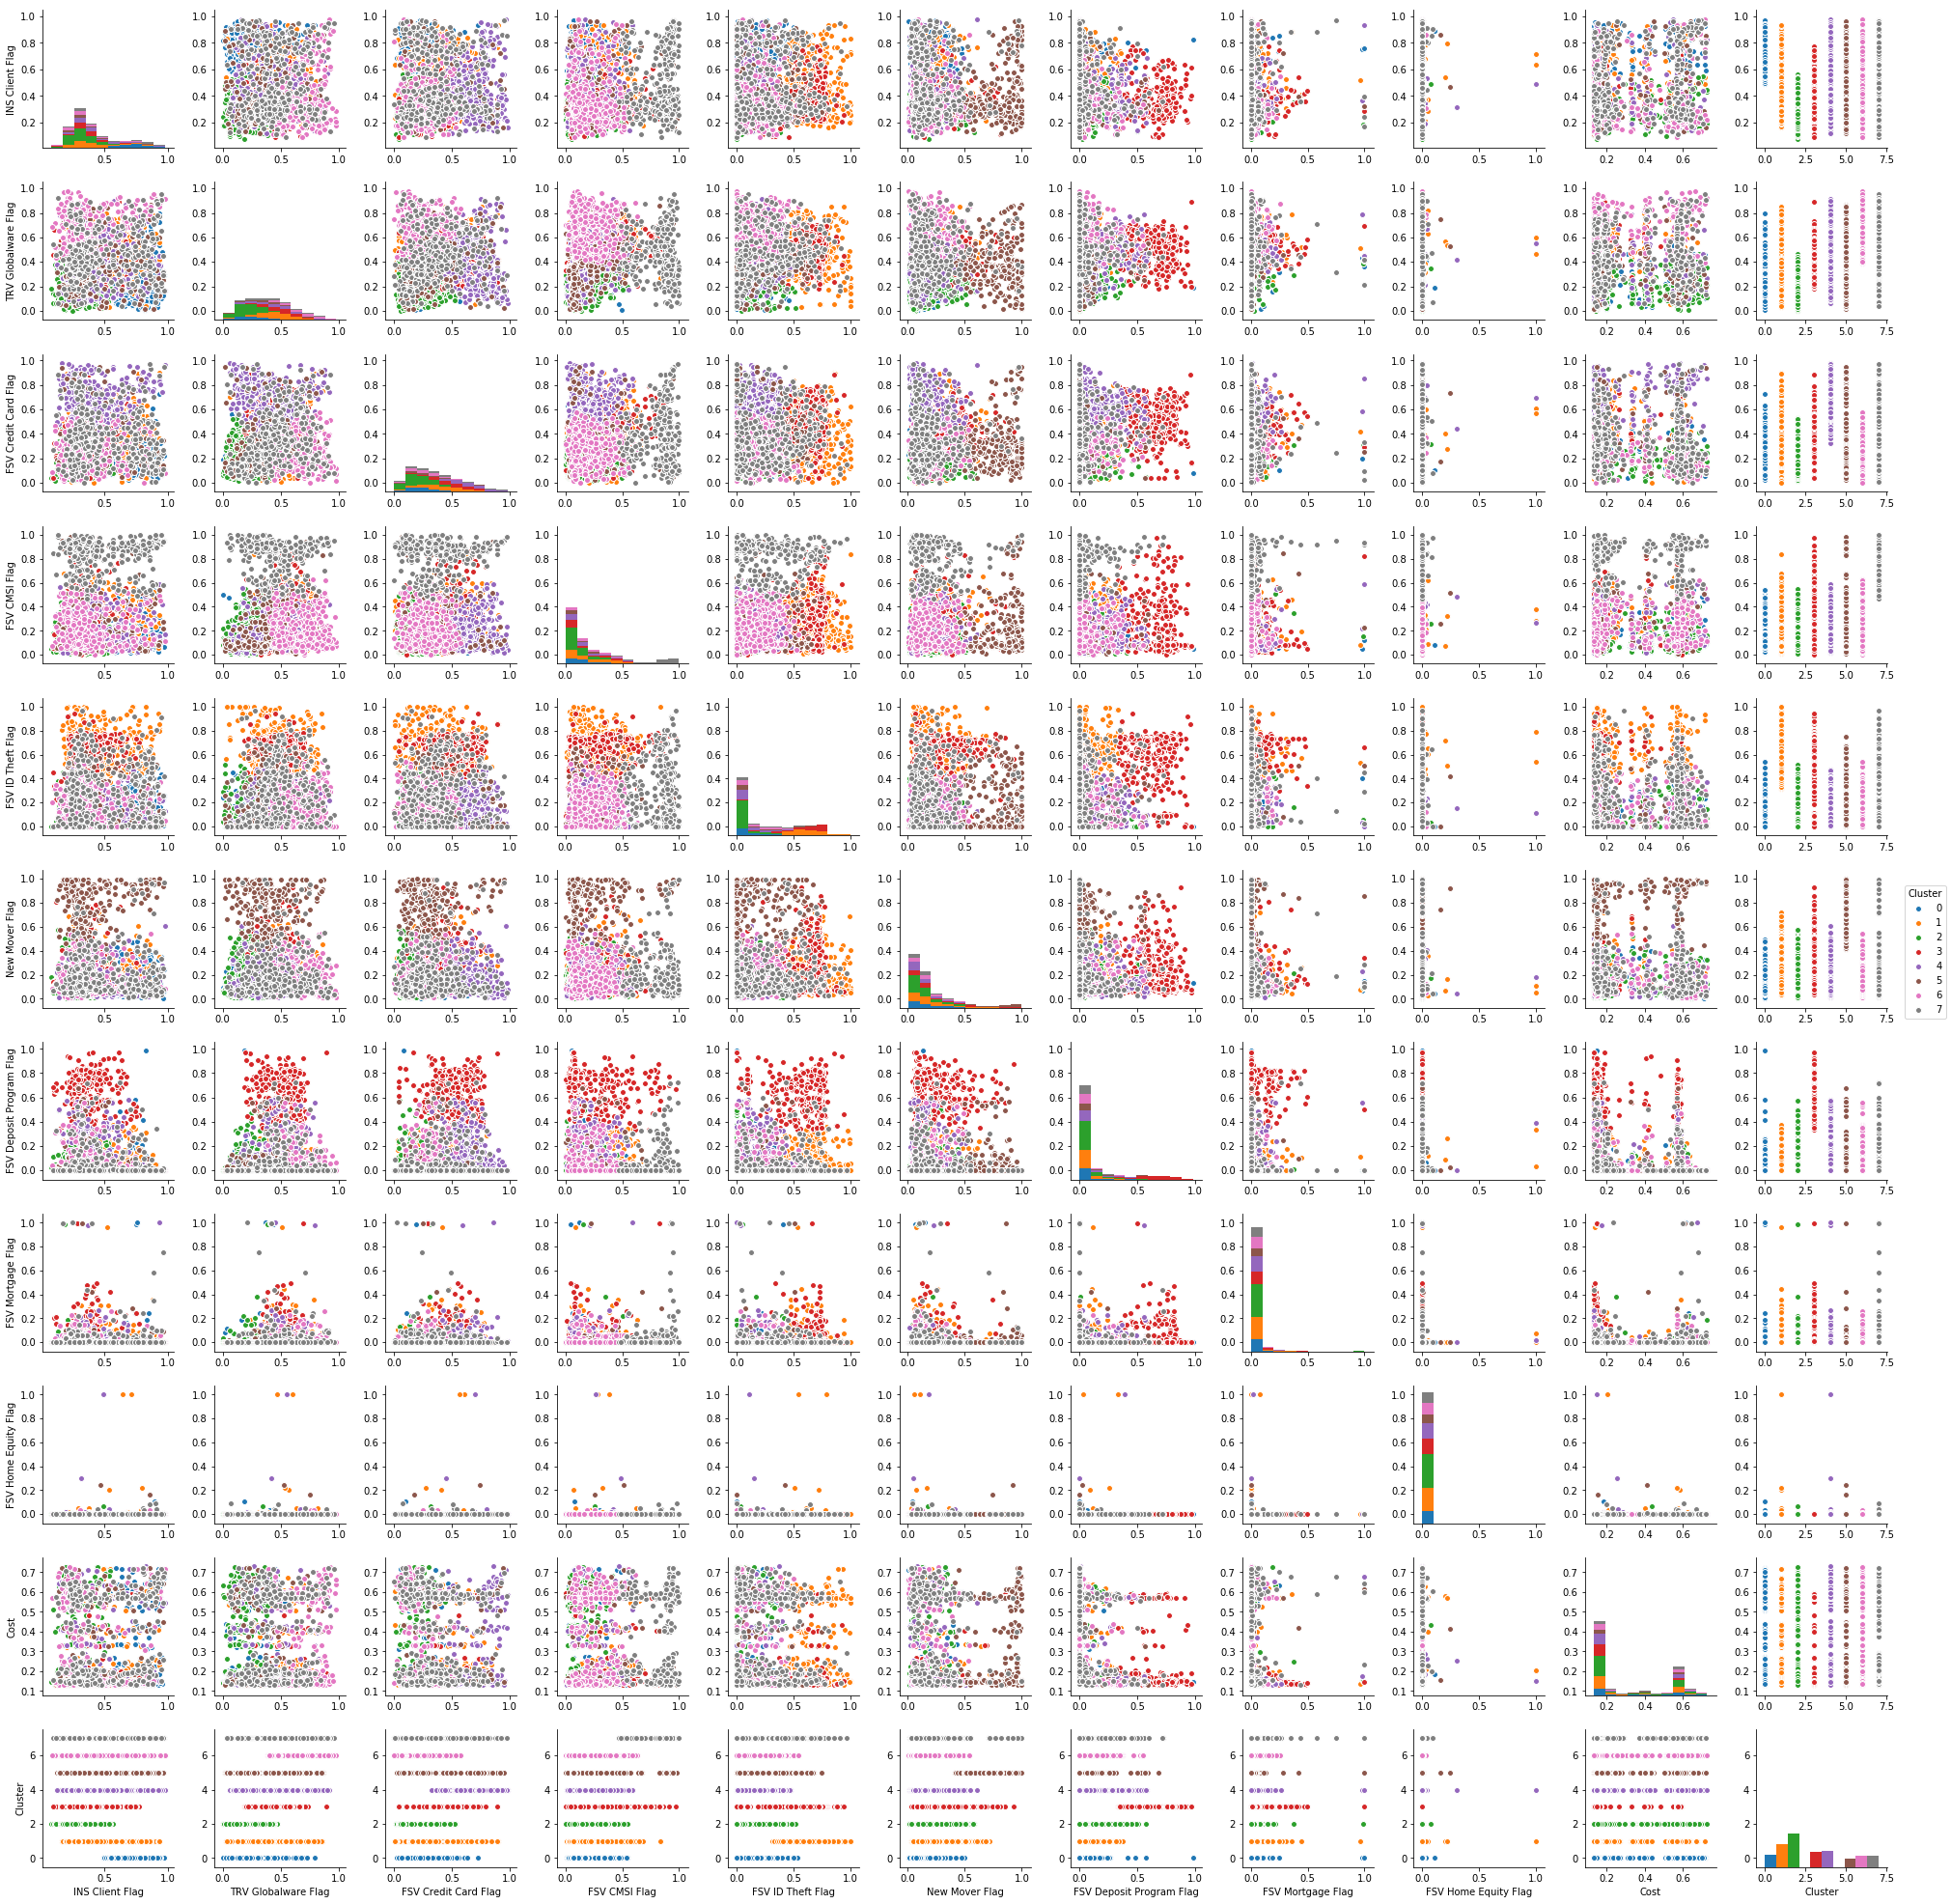

In [33]:
%%time
sns.pairplot(df_prob, hue='Cluster')
plt.show()

### Clustering Summary

#### Number of Clusters
- From the chart, it seems 3 clusters is the optimal choice, but it doesn't actually reveal any product-level insights for business action.
- When the households are clustered into **8 or 9 groups**, we can identify target audiences that shows high interest on a particular product for 7 products. 

#### Products
- The two products that do not have a particular cluster standing out are FSV Mortgage and FSV Home Equity, which also have the lowest market peneratration. For these two products, we could simply focus on individual households with high probability of purchasing instead of a particular group.

#### Cost
- In addition, predicted cost does not have any noticeable difference across clusters, partly because cost is hard to predict. The cost could possibly be generated randomly as a customer only needs it in emergency.

## Appendix
Applying other models - using 'INS Client Flag' as an example.

In [34]:
from sklearn.preprocessing import MinMaxScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

Wall time: 1min 37s


In [35]:
# Up Sampling
# Separate majority and minority classes
df_majority = df[df['INS Client Flag']==0]
df_minority = df[df['INS Client Flag']==1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, replace=True, 
                                 n_samples=len(df_majority), random_state=72)
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
    
cols = [x for x in df_upsampled.columns if (x not in product_list
                                           ) & (x not in ['Household Key', 'Total Cost sum'])]

X = df_upsampled[cols]
# Scale 
scaler = MinMaxScaler()
scaler.fit(X)
df_scaled = scaler.transform(X)

y = df_upsampled['INS Client Flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=75)

#### kNN

In [36]:
%%time
param_grid = {'n_neighbors': np.arange(8, 20)}
gs_kNN = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
gs_kNN.fit(X_train, y_train)
print("Best Number of Neighbors:", gs_kNN.best_params_)
print("Accuracy on Training Set:", gs_kNN.best_score_)

y_pred_prob = gs_kNN.predict_proba(X_test)[:,1]
print("Accuracy on Test Set:", gs_kNN.score(X_test, y_test))
print("AUC:", roc_auc_score(y_test, y_pred_prob))

Best Number of Neighbors: {'n_neighbors': 9}
Accuracy on Training Set: 0.5888475836431226
Accuracy on Test Set: 0.5966303270564915
AUC: 0.6263004871915763
Wall time: 1min 23s


#### Logistic Regression

In [37]:
%%time
param_grid = {'C': [15-6, 1e-5, 1e-4], 
              'tol': [10, 1, 0.1], 
              'max_iter': [1000, 1500]}
gs_lr = GridSearchCV(LogisticRegression(), param_grid, cv=5)
gs_lr.fit(X_train, y_train)
print("Best Parameters:", gs_lr.best_params_)
print("Accuracy on Training Set:", gs_lr.best_score_)

y_pred_prob = gs_lr.predict_proba(X_test)[:,1]
print("Accuracy on Test Set:", gs_lr.score(X_test, y_test))
print("AUC:", roc_auc_score(y_test, y_pred_prob))

Best Parameters: {'max_iter': 1000, 'C': 0.0001, 'tol': 10}
Accuracy on Training Set: 0.5563816604708798
Accuracy on Test Set: 0.5441030723488602
AUC: 0.5618890460474619
Wall time: 35.4 s


#### SVM
SVM takes too much time to train.

#### Random Forest

In [38]:
%%time
param_grid = {'n_estimators':[50, 100, 150],
              'max_depth': [3, 5], 
              'max_features': ['auto', 'sqrt']}
rf = RandomForestClassifier()
gs_rf = GridSearchCV(rf, param_grid, cv=5)
gs_rf.fit(X_train, np.ravel(y_train))
print("Best Parameters:", gs_rf.best_params_)
print("Accuracy on Training Set:", gs_rf.best_score_)

y_pred_prob = gs_rf.predict_proba(X_test)[:,1]
print("Accuracy on Test Set:", gs_rf.score(X_test, y_test))
print("AUC:", roc_auc_score(y_test, y_pred_prob))

Best Parameters: {'max_depth': 5, 'n_estimators': 100, 'max_features': 'auto'}
Accuracy on Training Set: 0.6034696406443618
Accuracy on Test Set: 0.6095143706640238
AUC: 0.6556498506993556
Wall time: 56.9 s


In [39]:
y_pred = gs_rf.predict(X_test)
pd.Series(y_pred).value_counts()

0.0    567
1.0    442
dtype: int64